Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To read the data

### Importing all the important libraries

In [1]:
import pathlib   # to read the train and test datasets from drive
import tensorflow as tf  # TensorFlow library
import matplotlib.pyplot as plt  # To plot graphs
import numpy as np    # To do mathematical operations
import pandas as pd   # To handle datasets, we use pandas
import os    # to execute OS based commands
import PIL    # to work with images
from tensorflow import keras   # To build the model
from tensorflow.keras import layers   # To build the model
from tensorflow.keras.models import Sequential   # To build the model

tf.get_logger().setLevel('ERROR')  # Eliminate the warnings

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## The paths of the train and test dataset from google drive
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
# Print the count of images in Train and Test datasets

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32   # batch size is defined as 32 to process
img_height = 180   # size of image is fixed with 180 by 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Visualize one instance of all the nine classes present in the dataset

Found 2239 files belonging to 9 classes.


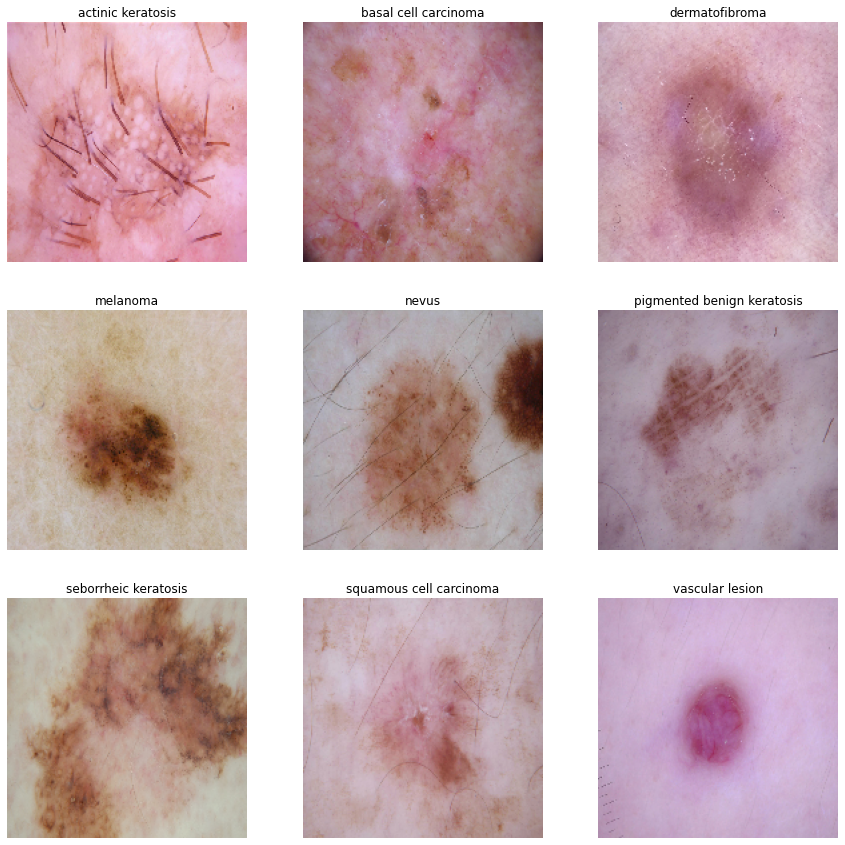

In [9]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

### your code goes here, you can use training or validation data to visualize
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(img_height,img_width)))
    plt.title(c)
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
### Define your classes
num_classes = 9

# Instantiate your sequential model in Keras with 3 Conv layers and 3 max pooling
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # Rescale your data
  layers.Conv2D(32, 3, padding='same', activation='relu'), # add convolution layer with 16 filters
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'), # add convolution layer with 32 filters
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'), # add convolution layer with 64 filters
  layers.MaxPooling2D(),
  layers.Flatten(),     # Flatten the 3D output that we received from Max Pool and Conv layers
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
### Using an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 218s 782ms/step - loss: 2.1136 - accuracy: 0.2227 - val_loss: 1.9135 - val_accuracy: 0.2864
Epoch 2/20
56/56 [==============================] - 2s 36ms/step - loss: 1.7581 - accuracy: 0.3772 - val_loss: 1.4918 - val_accuracy: 0.4810
Epoch 3/20
56/56 [==============================] - 2s 39ms/step - loss: 1.5382 - accuracy: 0.4660 - val_loss: 1.4183 - val_accuracy: 0.5123
Epoch 4/20
56/56 [==============================] - 2s 40ms/step - loss: 1.3849 - accuracy: 0.5201 - val_loss: 1.5491 - val_accuracy: 0.4609
Epoch 5/20
56/56 [==============================] - 2s 35ms/step - loss: 1.2850 - accuracy: 0.5458 - val_loss: 1.3575 - val_accuracy: 0.5302
Epoch 6/20
56/56 [==============================] - 2s 35ms/step - loss: 1.1970 - accuracy: 0.5792 - val_loss: 1.3815 - val_accuracy: 0.5347
Epoch 7/20
56/56 [==============================] - 2s 35ms/step - loss: 1.1110 - accuracy: 0.6211 - val_loss: 1.3270 - val_accuracy: 0.5369
Epoch 8/20

### Visualizing training results

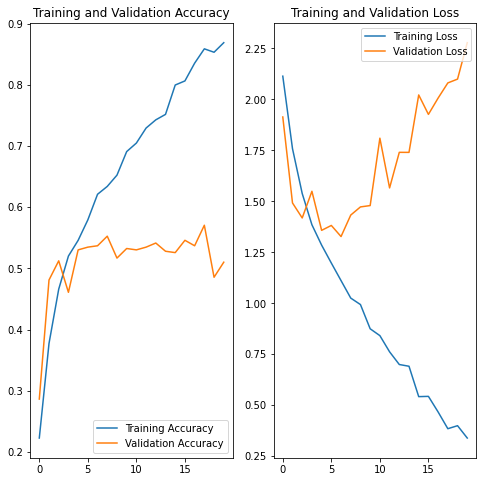

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings
- We see that Training accuracy and Validation accuracy differs a lot
- Training loss is reduced where as loss function is huge in case of Validation data set.

#### This clearly indicates overfitting

In [16]:
# After you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

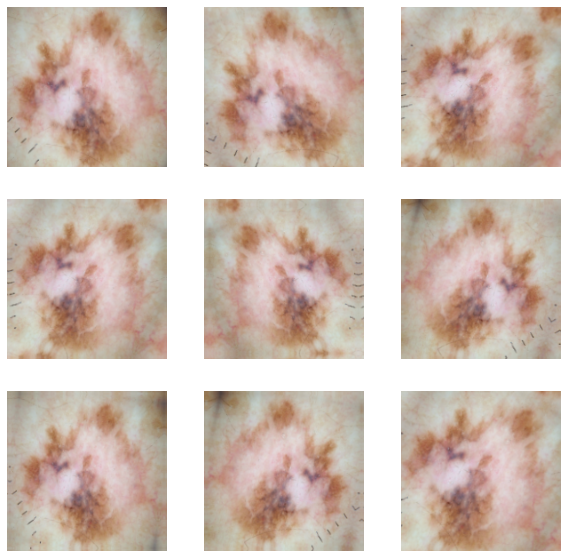

In [17]:
# Visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create the model, compile and train the model


In [18]:
## Dropout layer is used as there is overfitting

# Instantiate your sequential model in Keras with 3 Conv layers and 3 max pooling
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255), # Rescale your data
  layers.Conv2D(32, 3, padding='same', activation='relu'), # Three convolution and Max Pooling layers
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.30),   # Added a dropout to reduce overfitting
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.30),   # Added a dropout to reduce overfitting
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.30),
  layers.Dense(num_classes, activation='softmax')
])



### Compiling the model

In [19]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Training the model

In [20]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 16s 190ms/step - loss: 2.3324 - accuracy: 0.1931 - val_loss: 2.0451 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 11s 190ms/step - loss: 2.0569 - accuracy: 0.1864 - val_loss: 2.0231 - val_accuracy: 0.1991
Epoch 3/20
56/56 [==============================] - 10s 186ms/step - loss: 2.0322 - accuracy: 0.2137 - val_loss: 2.0169 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 9s 163ms/step - loss: 1.9933 - accuracy: 0.2656 - val_loss: 1.8917 - val_accuracy: 0.2506
Epoch 5/20
56/56 [==============================] - 11s 188ms/step - loss: 1.8227 - accuracy: 0.3482 - val_loss: 1.8287 - val_accuracy: 0.3758
Epoch 6/20
56/56 [==============================] - 11s 188ms/step - loss: 1.6896 - accuracy: 0.3990 - val_loss: 1.7146 - val_accuracy: 0.3647
Epoch 7/20
56/56 [==============================] - 10s 182ms/step - loss: 1.6195 - accuracy: 0.4241 - val_loss: 1.5070 - val_accuracy: 0.4810


### Visualizing the results

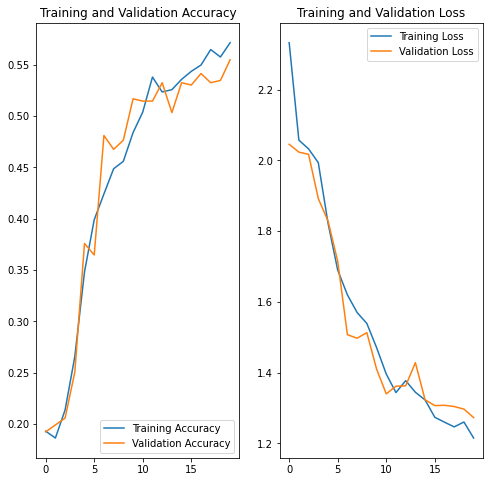

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings after using dropouts

- We see the overfit is removed or reduced with the model behaving in accurate way for both Train and Validation data sets
- However, we see the model accuracy is at 55% and it can further be improved

#### The distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [22]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [23]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Skin cancer ISIC The I...,basal cell carcinoma
1,/content/gdrive/MyDrive/Skin cancer ISIC The I...,basal cell carcinoma
2,/content/gdrive/MyDrive/Skin cancer ISIC The I...,basal cell carcinoma
3,/content/gdrive/MyDrive/Skin cancer ISIC The I...,basal cell carcinoma
4,/content/gdrive/MyDrive/Skin cancer ISIC The I...,basal cell carcinoma
...,...,...
2234,/content/gdrive/MyDrive/Skin cancer ISIC The I...,seborrheic keratosis
2235,/content/gdrive/MyDrive/Skin cancer ISIC The I...,seborrheic keratosis
2236,/content/gdrive/MyDrive/Skin cancer ISIC The I...,seborrheic keratosis
2237,/content/gdrive/MyDrive/Skin cancer ISIC The I...,seborrheic keratosis


Class=1, n=376 (16.793%)
Class=4, n=357 (15.945%)
Class=7, n=181 (8.084%)
Class=5, n=462 (20.634%)
Class=2, n=95 (4.243%)
Class=3, n=438 (19.562%)
Class=0, n=114 (5.092%)
Class=8, n=139 (6.208%)
Class=6, n=77 (3.439%)


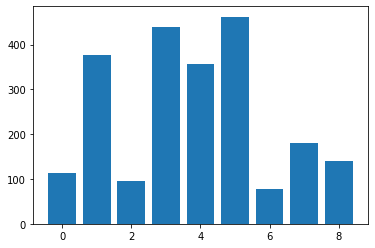

In [24]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

#### Findings from the count: 
#### - We see that classes 2 and 6 are having less than 5% of the data
#### - The classes 3 and 5 dominate others


#### Rectifying the class imbalance using Augmentor
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [25]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [26]:
path_to_training_dataset="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)   # Replicate images with 10 pixel rotation for each iteration
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC768184BB0>: 100%|██████████| 500/500 [00:28<00:00, 17.49 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC76814AA90>: 100%|██████████| 500/500 [00:26<00:00, 19.00 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC768149940>: 100%|██████████| 500/500 [00:21<00:00, 23.25 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7FC7681C84C0>: 100%|██████████| 500/500 [01:56<00:00,  4.31 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x7FC768125250>: 100%|██████████| 500/500 [01:44<00:00,  4.77 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC768105A00>: 100%|██████████| 500/500 [00:21<00:00, 23.80 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FC91C210220>: 100%|██████████| 500/500 [00:48<00:00, 10.24 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC768119AC0>: 100%|██████████| 500/500 [00:20<00:00, 24.73 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC7681048E0>: 100%|██████████| 500/500 [00:22<00:00, 22.64 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [27]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [28]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027337.jpg_39f87f02-4172-4229-b5dd-0536403a818d.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027545.jpg_e618e9e6-419e-4907-828f-1fa6cc26cb37.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025019.jpg_ebdce26e-3fa4-46d3-8e5d-40bc024bc469.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030177.jpg_443f9d2c-0085-40a3-ac9b-2284ca36d51a.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_

In [29]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',


In [30]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [31]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [32]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

Class=1, n=876 (12.999%)
Class=4, n=857 (12.717%)
Class=7, n=681 (10.105%)
Class=5, n=962 (14.275%)
Class=2, n=595 (8.829%)
Class=3, n=938 (13.919%)
Class=0, n=614 (9.111%)
Class=8, n=639 (9.482%)
Class=6, n=577 (8.562%)


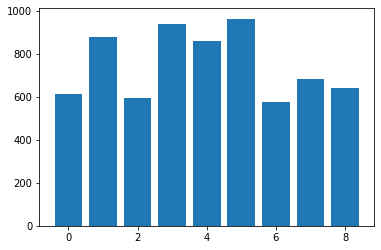

In [33]:
# split into input and output elements
X, y = new_df['Path'], new_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

## Train the model on the data created using Augmentor

In [34]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [35]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',## choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [36]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create your model (make sure to include normalization)

In [37]:
## Rescale, Build the model with 3 Conv layers and Max Pooling, with droputs specified
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.30),   # Added a dropout to reduce overfitting
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),   # Added a dropout to reduce overfitting
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.30),
  layers.Dense(num_classes, activation='softmax')
])

#### Compile your model (Choose optimizer and loss function appropriately)

In [38]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

#### Train your model

In [39]:
epochs = 30
## Use 30 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 55s 101ms/step - loss: 2.0176 - accuracy: 0.2971 - val_loss: 2.1089 - val_accuracy: 0.1804
Epoch 2/30
169/169 [==============================] - 11s 66ms/step - loss: 1.5316 - accuracy: 0.4262 - val_loss: 1.8174 - val_accuracy: 0.3311
Epoch 3/30
169/169 [==============================] - 11s 66ms/step - loss: 1.3555 - accuracy: 0.4952 - val_loss: 1.3233 - val_accuracy: 0.5167
Epoch 4/30
169/169 [==============================] - 11s 68ms/step - loss: 1.1967 - accuracy: 0.5497 - val_loss: 1.0224 - val_accuracy: 0.6548
Epoch 5/30
169/169 [==============================] - 11s 65ms/step - loss: 1.0340 - accuracy: 0.6189 - val_loss: 0.9242 - val_accuracy: 0.6503
Epoch 6/30
169/169 [==============================] - 11s 66ms/step - loss: 0.9314 - accuracy: 0.6597 - val_loss: 0.8649 - val_accuracy: 0.7097
Epoch 7/30
169/169 [==============================] - 11s 65ms/step - loss: 0.7786 - accuracy: 0.7107 - val_loss: 0.7311 - val_accuracy

####  Visualize the model results

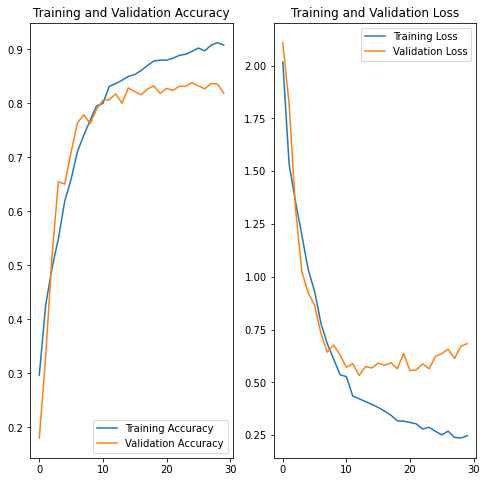

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Final output

- After using Batch Normalization, Dropouts, we see there is huge improvement in performance
- The accuracy is greater than ~80% for both validation and train
- There is no over fitting and no underfitting
- The loss function is reduced



In [41]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [42]:
train_loss, train_acc = model.evaluate(train_ds)
print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')
print("#" * 50)

val_loss, val_acc = model.evaluate(val_ds)
print(f'Validation loss: {val_loss}, Validation accuracy: {val_acc}')
print("#" * 50)

test_loss, test_acc = model.evaluate(test_ds)
print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')

169/169 [==============================] - 2s 13ms/step - loss: 0.1219 - accuracy: 0.9572
Train loss: 0.12189353257417679, Train accuracy: 0.9571587443351746
##################################################
43/43 [==============================] - 1s 13ms/step - loss: 0.6829 - accuracy: 0.8189
Validation loss: 0.68292236328125, Validation accuracy: 0.8188567161560059
##################################################
4/4 [==============================] - 20s 89ms/step - loss: 7.2139 - accuracy: 0.3644
Test loss: 7.2139153480529785, Test accuracy: 0.3644067943096161


### To Summarize- the model is working with 95% on Train dataset and 81% on Validatation dataset.

However, the model is performing slightly less on Test dataset with 36% accuracy